In [1]:
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np

from curvelops import FDCT2D

import os
dir_path = os.path.dirname(os.path.realpath('..'))

import sys
sys.path.append('../../adasubtraction')     # add path to adasubtraction

from read_gathers import read_gathers
from adasubtraction_qc import adasubtraction_qc
from curvelet_separation import curvelet_separation

In [2]:
fsynth = np.load('/home/wwd/Adaptive-subtraction/data/input_full_volvesynth.npz')

In [3]:
psynth = fsynth['p'].transpose(0, 2, 1)

ns = psynth.shape[0]
nr = psynth.shape[1]
nt = psynth.shape[2]
psynth.shape

(110, 180, 2351)

In [4]:
t = fsynth['t']
tsynth = fsynth['t']
dt = t[1]-t[0]
dt

0.002

In [5]:
rsynth = fsynth['r']
dr = np.round(rsynth[0,1]-rsynth[0,0])
dr

25.0

In [ ]:
isrc = 60

# cut data, make sure ns == nr
psynth_sample = psynth[:, 35: -35, :1500]

ns = psynth_sample.shape[0]
nr = psynth_sample.shape[1]
nt = psynth_sample.shape[2]
# np.save('../../data/psynth_sample.npy', psynth_sample)

psynth_sample.shape

(110, 110, 1500)

(3763.201416015625, 8244.96875, 3.0, 0.0)

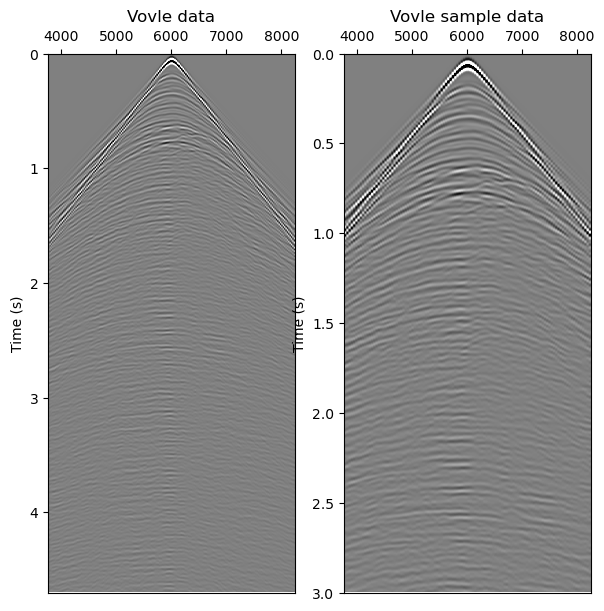

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7))

pclip = 0.2
axs[0].imshow(
    psynth[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(psynth[isrc, :, :]).max(),
    vmax=pclip * np.abs(psynth[isrc, :, :]).max(),
    extent = (rsynth[0,0],rsynth[0,-1], tsynth[-1], tsynth[0])
)

axs[0].set(ylabel="Time (s)", title="Vovle data")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    psynth_sample[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(psynth_sample[isrc, :, :]).max(),
    vmax=pclip * np.abs(psynth_sample[isrc, :, :]).max(),
    extent = (rsynth[0,0],rsynth[0,-1], dt*nt, 0)
)

axs[1].set(ylabel="Time (s)", title="Vovle sample data")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

In [8]:
p = 3  # 通过p来分割数据的最后一维，并进行填充
data_p = np.concatenate((psynth_sample, np.zeros((psynth_sample.shape[0],
                                                psynth_sample.shape[1],
                                                psynth_sample.shape[2] // p))), axis=-1)
data_p.shape

(110, 110, 2000)

In [9]:
data_fft = np.fft.rfft(data_p, axis=-1)
data_fft = data_fft.transpose(2, 0, 1).astype(np.complex64)

In [10]:
# Create the multi-dimensional convolution operator
import pylops
MDCop = pylops.waveeqprocessing.MDC(
    data_fft,
    nt=data_p.shape[2],      # number of time samples
    nv=data_p.shape[0],      # number of sources
    dt=dt,
    dr=dr,
    twosided = False,
)
MDCop.shape

/home/wwd/miniconda3/envs/pylops_37/lib/python3.7/site-packages/pylops/signalprocessing/fft.py:53: UserWarning: numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to complex64.
  f"numpy backend always returns complex128 dtype. To respect the passed dtype, data will be casted to {self.cdtype}."


(24200000, 24200000)

In [11]:
multiples =  MDCop @ data_p.transpose(2, 1, 0).ravel()

In [12]:
multiples = multiples.reshape(data_p.shape[2], ns, nr)
multiples = multiples.transpose(1, 2, 0)
multiples = multiples[:,:, :nt]
multiples.shape

(110, 110, 1500)

In [13]:
print(' Min of multiples:', np.min(multiples), '\n', 'Max of multiples:', 
      np.max(multiples), '\n', 'Mean of Multiples', np.mean(multiples))
print('\n')
print(' Min of psynth_sample:', np.min(psynth_sample), '\n', 'Max of psynth_sample:', 
      np.max(psynth_sample), '\n', 'Mean of psynth_sample', np.mean(psynth_sample))

 Min of multiples: -42613793000.0 
 Max of multiples: 42830040000.0 
 Mean of Multiples -45522.195


 Min of psynth_sample: -15823.433 
 Max of psynth_sample: 12351.368 
 Mean of psynth_sample 0.005269706


(0.0, 110.0, 3.0, 0.0)

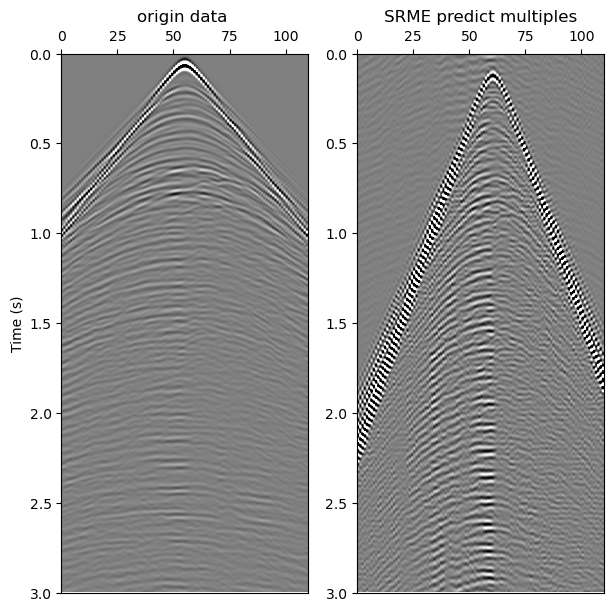

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7))

axs[0].imshow(
    psynth_sample[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(psynth_sample[isrc, :, :]).max(),
    vmax=pclip * np.abs(psynth_sample[isrc, :, :]).max(),
    extent=(0, nr, nt*dt, 0)
)
axs[0].set(ylabel="Time (s)", title="origin data ")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    multiples[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples[isrc, :, :]).max(),
    extent=(0, nr, nt*dt, 0)
)
axs[1].set(title="SRME predict multiples")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

In [15]:
# def shift_up(arr, n):
#     _, _, rows = arr.shape
#     result = np.zeros_like(arr)
#     result[:, :, :rows-n] = arr[:, :, n:]
#     return result

# # 35 is a trick
# multiples = shift_up(multiples, 30)
multiples *= -0.8 * np.max(np.abs(psynth_sample)) / np.max(abs(multiples))

In [16]:
# Select number of scales and wedges

sc = 10
w_n = 8

# Create Operator

C2D = FDCT2D(psynth_sample[isrc, :, :].shape, nbscales=sc, nbangles_coarse=w_n, allcurvelets=False)

In [17]:
# Input parameters
eps1 = 2 # 原始波（s1）的正则化参数，控制软阈值的程度
eps2 = 0.1 # 多次波（s2）的正则化参数，控制软阈值的程度
eta = 1 # 正则化参数，平衡数据拟合项和正则化项之间的权重

# Apply bayes separation algorithm (Saab et al. 2007)
s1  = curvelet_separation(C2D, psynth_sample[isrc, :, :], multiples[isrc, :, :], eps1, eps2, eta, niter=300)
s1.shape

(110, 1500)

(0.0, 110.0, 3.0, 0.0)

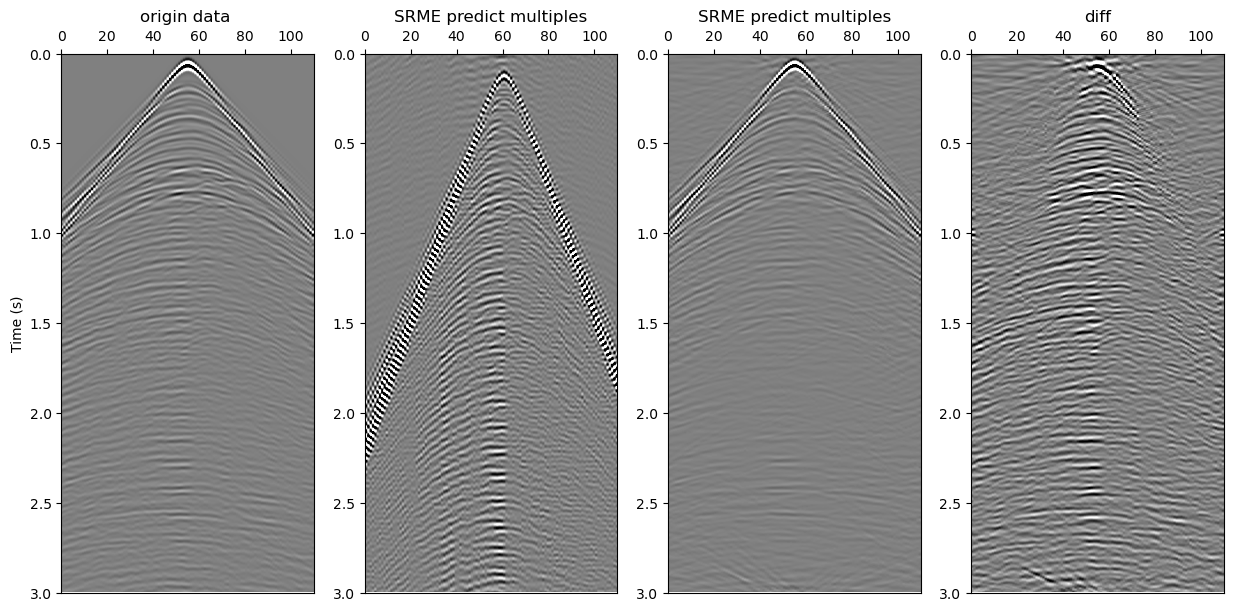

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(15, 7))

axs[0].imshow(
    psynth_sample[isrc,: , :].T,
    cmap="gray",
    vmin=-pclip * np.abs(psynth_sample[isrc, :, :]).max(),
    vmax=pclip * np.abs(psynth_sample[isrc, :, :]).max(),
    extent=(0, nr, nt*dt, 0)
)
axs[0].set(ylabel="Time (s)", title="origin data ")
axs[0].xaxis.set_ticks_position('top')
axs[0].axis("tight")

axs[1].imshow(
    multiples[isrc, :, :].T,
    cmap="gray",
    vmin=-pclip * np.abs(multiples[isrc, :, :]).max(),
    vmax=pclip * np.abs(multiples[isrc, :, :]).max(),
    extent=(0, nr, nt*dt, 0)
)
axs[1].set(title="SRME predict multiples")
axs[1].xaxis.set_ticks_position('top')
axs[1].axis("tight")

axs[2].imshow(
    s1.T,
    cmap="gray",
    vmin=-pclip * np.abs(s1).max(),
    vmax=pclip * np.abs(s1).max(),
    extent=(0, nr, nt*dt, 0)
)
axs[2].set(title="SRME predict multiples")
axs[2].xaxis.set_ticks_position('top')
axs[2].axis("tight")

diff = psynth_sample[isrc, :, :] - s1
axs[3].imshow(
    diff.T,
    cmap="gray",
    vmin=-pclip * np.abs(diff).max(),
    vmax=pclip * np.abs(diff).max(),
    extent=(0, nr, nt*dt, 0)
)
axs[3].set(title="diff")
axs[3].xaxis.set_ticks_position('top')
axs[3].axis("tight")

In [19]:
print(' Min of multiples:', np.min(multiples), '\n', 'Max of multiples:', 
      np.max(multiples), '\n', 'Mean of Multiples', np.mean(multiples))
print('\n')
print(' Min of psynth_sample:', np.min(psynth_sample), '\n', 'Max of psynth_sample:', 
      np.max(psynth_sample), '\n', 'Mean of psynth_sample', np.mean(psynth_sample))
print('\n')
print(' Min of s1:', np.min(s1), '\n', 'Max of s1:', 
      np.max(s1), '\n', 'Mean of s1', np.mean(s1))

 Min of multiples: -12658.746 
 Max of multiples: 12594.832 
 Mean of Multiples 0.01345446


 Min of psynth_sample: -15823.433 
 Max of psynth_sample: 12351.368 
 Mean of psynth_sample 0.005269706


 Min of s1: -13074.839852552223 
 Max of s1: 10324.946443844057 
 Mean of s1 -0.0005139358616584049


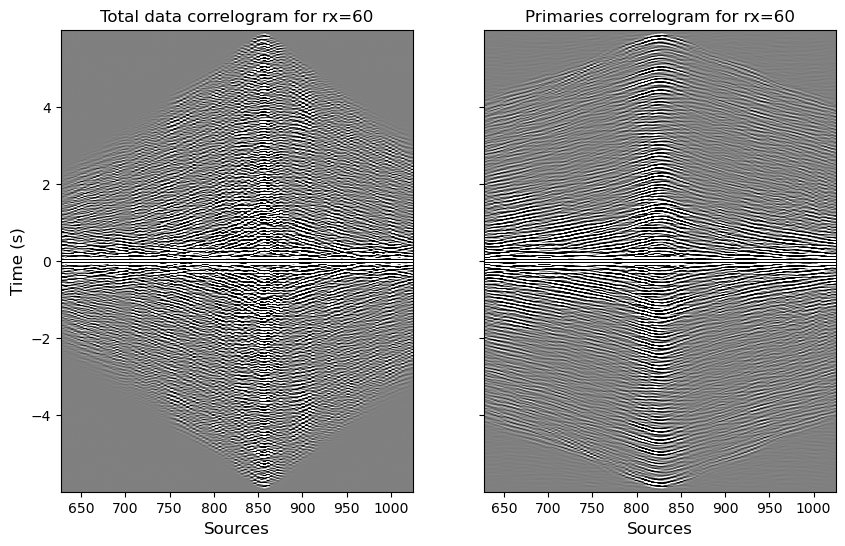

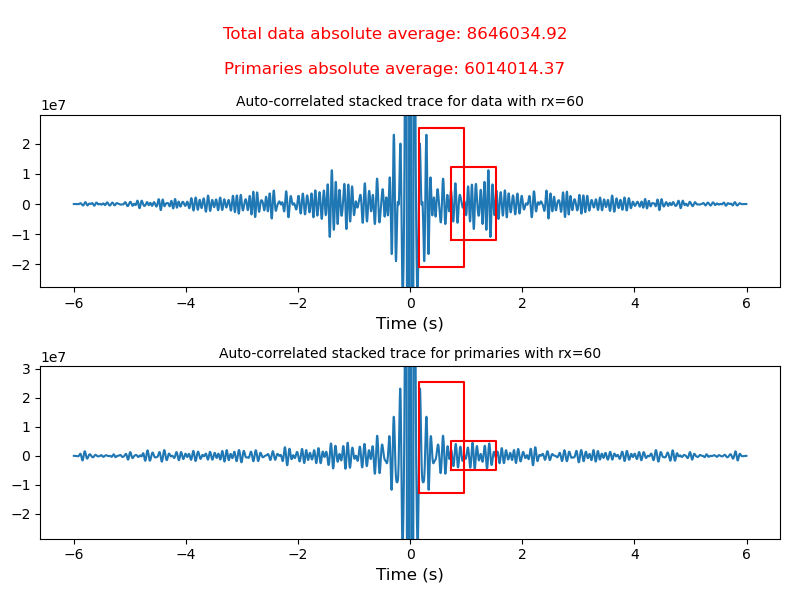

In [20]:
adasubtraction_qc(psynth_sample[:, isrc, :], s1, gather_num=isrc)